<a href="https://colab.research.google.com/github/Ori226/CenterNet_TensorFlow2/blob/master/beyond_top1_paper_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reproducing Main Results from "Looking Beyond the Top-1: Transformers Determine Top Tokens in Order" Paper
This notebook reproduces the two main experiments from the paper "Looking Beyond the Top-1: Transformers Determine Top Tokens in Order" (Section 2) on pre-trained Llama3-8B model.

The first experiment establishes the ordered nature of top-k saturation events (Section 2.2), while the second experiment (Section 2.3) uses a probing approach to show that it is possible to determine with high accuracy the rank of the token currently being determined by the model solely from intermediate layer activations.

Additionally, the notebook demonstrates that top-1 saturation events are common for this model and corpus, highlighting the broader relevance of the paper.

The whole notebook should take about 10 minutes to run on a T4 machine.


### Setup Environment
This cell imports necessary libraries for running the experiments.

In [4]:
!pip install -q numpy
import numpy as np

print(np.__version__)
!pip install -q -U transformers
!pip install -q accelerate sentencepiece
!pip install -q datasets
#==15.0.2
!pip install -q  pyarrow
!pip install -q -U bitsandbytes

1.26.4


### Consts
This cell sets up the consts used in the experiments. Please fill in your HuggingFace token.

In [1]:
MODEL_NAME = "meta-llama/Meta-Llama-3-8B"
# MODEL_NAME = "meta-llama/Llama-3.2-11B-Vision"
INPUT_LENGTH = 1024
NUM_TEXTS = 100
SATURATION_LAYER_RATIO = 0.85
TOP_K = 4
NUM_PROBING_CLASSES = 3
NUM_KFOLDS = 5
MIN_NUM_SAMPLES_FOR_TRAINING = 10

from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

### Loading Pre-trained Model (Llama3)
This cell loads a pre-trained Transformer model and tokenizer, which will be used throughout the experiments, specifically a 8-bit quantized version of Llama3-8B.

**Note**: Llama3 is a gated repo on HuggingFace, so if you've never used this model before you'll need to ask for access: https://huggingface.co/meta-llama/Meta-Llama-3-8B

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig ,BitsAndBytesConfig

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_auth_token=HF_TOKEN)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto",
                                             quantization_config=BitsAndBytesConfig(load_in_8bit=True, bnb_4bit_compute_dtype=torch.bfloat16),
                                             use_auth_token=HF_TOKEN)
model.eval()

config = AutoConfig.from_pretrained(MODEL_NAME, use_auth_token=HF_TOKEN)
num_layers = config.num_hidden_layers

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/tokenization_auto.py:1041: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/configuration_auto.py:1317: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


In [12]:
config.num_hidden_layers

32

In [1]:
%%writefile requirements.txt
torch
numpy
transformers
accelerate
sentencepiece
datasets
pyarrow==15.0.2
bitsandbytes
matplotlib
scipy
scikit-learn


Writing requirements.txt


Next, let's create the `Dockerfile`.

In [2]:
%%writefile Dockerfile
FROM pytorch/pytorch:2.1.0-cuda11.8-cudnn8-runtime

WORKDIR /app

# Install system dependencies that might be needed (e.g. for bitsandbytes)
RUN apt-get update && apt-get install -y --no-install-recommends \
    build-essential \
    git \
    && rm -rf /var/lib/apt/lists/*

# Copy requirements.txt and install Python dependencies
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copy your notebook. Please rename 'your_notebook_name.ipynb' to the actual notebook file name.
# If your notebook is named 'Reproducing_Main_Results_from_Looking_Beyond_the_Top_1_Transformers_Determine_Top_Tokens_in_Order_Paper.ipynb'
# then you should change the line below to:
# COPY Reproducing_Main_Results_from_Looking_Beyond_the_Top_1_Transformers_Determine_Top_Tokens_in_Order_Paper.ipynb .
COPY your_notebook_name.ipynb .

# Expose the default Jupyter port
EXPOSE 8888

# Command to start Jupyter Lab
CMD ["jupyter", "lab", "--port=8888", "--no-browser", "--allow-root", "--ip=0.0.0.0"]


Writing Dockerfile


Now, the `docker-compose.yml` file.

In [3]:
%%writefile docker-compose.yml
version: '3.8'
services:
  notebook:
    build:
      context: .
      dockerfile: Dockerfile
    ports:
      - "8888:8888"
    volumes:
      - .:/app
    command: jupyter lab --port=8888 --no-browser --allow-root --ip=0.0.0.0
    deploy:
      resources:
        reservations:
          devices:
            - driver: nvidia
              count: all
              capabilities: [gpu]
    # Uncomment the following lines and replace with your actual HuggingFace token
    # environment:
    #   - HF_TOKEN="your_huggingface_token_here"


Writing docker-compose.yml


And finally, the `README.md` to explain how to use these files.

In [4]:
%%writefile README.md
# Reproducible Notebook Environment with Docker

This directory contains files to set up a reproducible environment for your Jupyter notebook using Docker and Docker Compose. This ensures that the notebook runs with consistent dependencies and configurations across different machines.

## Files Included

*   `requirements.txt`: Lists all Python package dependencies.
*   `Dockerfile`: Defines the Docker image, including the base image, system dependencies, and Python package installations.
*   `docker-compose.yml`: Configures a Docker Compose service to build and run the Jupyter Lab environment.

## Prerequisites

Before you begin, ensure you have the following installed on your system:

*   [Docker](https://docs.docker.com/get-docker/)
*   [Docker Compose](https://docs.docker.com/compose/install/)
*   [NVIDIA Container Toolkit](https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/install-guide.html) (if you plan to use GPU acceleration)

## Setup and Usage

1.  **Place your Notebook:** Make sure your Jupyter notebook file (e.g., `Reproducing_Main_Results_from_Looking_Beyond_the_Top_1_Transformers_Determine_Top_Tokens_in_Order_Paper.ipynb`) is in the same directory as these files.

2.  **Update `Dockerfile`:**
    *   Open `Dockerfile` and **replace `your_notebook_name.ipynb`** with the exact filename of your notebook. For example, if your notebook is named `Reproducing_Main_Results_from_Looking_Beyond_the_Top_1_Transformers_Determine_Top_Tokens_in_Order_Paper.ipynb`, change the line `COPY your_notebook_name.ipynb .` to `COPY Reproducing_Main_Results_from_Looking_Beyond_the_Top_1_Transformers_Determine_Top_Tokens_in_Order_Paper.ipynb .`

3.  **Handle HuggingFace Token (Important!):**
    Your notebook uses `HF_TOKEN = userdata.get('HF_TOKEN')`. This Colab-specific method won't work in Docker. You have two main options:

    *   **Option A (Recommended): Environment Variable:**
        1.  In your notebook, modify the line that fetches the `HF_TOKEN` to read from an environment variable: `import os; HF_TOKEN = os.environ.get('HF_TOKEN')`
        2.  When running Docker, pass your token as an environment variable.

    *   **Option B (Less Secure): Hardcode in Notebook:**
        You can directly replace `userdata.get('HF_TOKEN')` with your token string (e.g., `HF_TOKEN = "hf_YOUR_TOKEN_HERE"`). **This is generally not recommended for security reasons, especially if you share your code.**

4.  **Choose your method to run:**

### Method 1: Using `docker build` and `docker run`

1.  **Build the Docker Image:**
    Open your terminal, navigate to this directory, and run:
    ```bash
    docker build -t colab-notebook-env .
    ```
    This command builds a Docker image named `colab-notebook-env` based on the `Dockerfile`.

2.  **Run the Docker Container:**
    Once the image is built, run the container. If you are using Option A for the HuggingFace token, include the `-e HF_TOKEN` flag:
    ```bash
    docker run -it --rm --gpus all -p 8888:8888 -v "$(pwd)":/app -e HF_TOKEN="your_huggingface_token_here" colab-notebook-env
    ```
    *   `--gpus all`: Enables GPU access (requires NVIDIA Container Toolkit).
    *   `-p 8888:8888`: Maps the container's port 8888 to your host's port 8888.
    *   `-v "$(pwd)":/app`: Mounts your current directory into the `/app` folder inside the container, allowing persistent access to your notebook.
    *   `-e HF_TOKEN="your_huggingface_token_here"`: Sets the `HF_TOKEN` environment variable inside the container.

    The command will output a URL with a token. Copy and paste this URL into your web browser to access Jupyter Lab.

### Method 2: Using Docker Compose

1.  **Configure `docker-compose.yml` (if using environment variable for token):**
    If you are using Option A for the HuggingFace token, uncomment the `environment` section in `docker-compose.yml` and replace `"your_huggingface_token_here"` with your actual token:
    ```yaml
    environment:
      - HF_TOKEN="hf_xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
    ```

2.  **Build and Run with Docker Compose:**
    Open your terminal, navigate to this directory, and run:
    ```bash
    docker-compose up --build
    ```
    This command builds the image (if not already built or if changes were made to the `Dockerfile`) and starts the Jupyter Lab service.

    Similar to `docker run`, the output will provide a URL with a token. Copy it to your web browser to access Jupyter Lab.

## Stopping the Container

*   **For `docker run`:** Press `Ctrl+C` in the terminal where the container is running.
*   **For `docker-compose up`:** Press `Ctrl+C` in the terminal, then run `docker-compose down` to stop and remove the services and networks defined in `docker-compose.yml`.


Writing README.md


### Sampling random questions from MMLU dataset

In [9]:
from datasets import load_dataset
import numpy as np

answer_letters = {0: "A", 1: "B", 2: "C", 3:"D"}

def format_multi_choice_question(question, choices, answer):
  final_format = "Question: " + question
  final_format += f"\n A. {choices[0]}\nB. {choices[1]}\nC. {choices[2]}\n D. {choices[3]}"
  final_format += f"\nAnswer: {answer_letters[answer]}. {choices[answer]}"
  return final_format

dataset = load_dataset("cais/mmlu", "all", split="test")
questions = dataset["question"]
choices = dataset["choices"]
answers = dataset["answer"]
random_indxs = np.random.permutation(range(len(questions)))[:NUM_TEXTS]
texts = [format_multi_choice_question(questions[int(ind)], choices[int(ind)], answers[int(ind)]) for ind in random_indxs]

In [10]:
texts

['Question: It is characteristic of brief crisis-oriented therapy to\n A. explore early childhood experiences related to the problem\nB. try to ensure that the client becomes calm and relaxed\nC. agree upon clear-cut goals and keep the sessions focused on these goals\n D. be open and nondirective, allowing the client the greatest latitude in exploring all aspects of the crisis situation\nAnswer: C. agree upon clear-cut goals and keep the sessions focused on these goals',
 'Question: A cell is placed into a hypertonic environment and its cytoplasm shrivels up. This demonstrates the principle of\n A. diffusion.\nB. active transport.\nC. facilitated diffusion.\n D. plasmolysis.\nAnswer: D. plasmolysis.',
 'Question: This question refers to the following information.\n"At least one of the [world\'s] societies would have to somehow enormously increase its productivity [in order to achieve global hegemony]. That quantum jump would have to be made before the various scientific, technological,

### Extracting rankings and embeddings from model layers during inference using the logit-lens

In [5]:
from tqdm import tqdm
from collections import defaultdict
import pickle


def tokenize_text(tokenizer, text):
    """Tokenizes and truncates the input text to a fixed length."""
    input_ids = tokenizer(text, return_tensors="pt").input_ids
    input_ids = input_ids[:INPUT_LENGTH]
    return input_ids


def extract_hidden_layer_ranking_and_embedding(model, tokenizer, text, num_layers):
    """Extracts top-k token rankings and embeddings from each hidden layer."""
    input_ids = tokenize_text(tokenizer, text).to(model.device)
    indices_per_layer, embeddings_per_layer = [], []

    with torch.no_grad():
        torch.cuda.empty_cache()
        outputs = model(input_ids, return_dict=True, output_hidden_states=True, use_cache=False)

        for i, hidden_state in enumerate(outputs.hidden_states[1:], start=1):
            norm_hidden = model.model.norm(hidden_state).detach() if i != num_layers else hidden_state.detach()
            logits = model.lm_head(norm_hidden).float().cpu()
            top_indices = torch.topk(logits.squeeze(), TOP_K, dim=-1).indices.numpy()
            indices_per_layer.append(top_indices)
            embeddings_per_layer.append(norm_hidden.reshape(-1, norm_hidden.size(-1)).cpu().numpy())

    del outputs
    return np.array(indices_per_layer), np.array(embeddings_per_layer)


def calc_top_k_saturation_layers(indices_per_layer, num_layers):
    """Calculates the top-k saturation layers as defined in the paper."""
    saturation_layers = []
    final_layer_indices = indices_per_layer[-1]

    for k in range(TOP_K):
        final_decision = final_layer_indices[:, k]
        token_mismatch = np.not_equal(indices_per_layer[:, :, k], final_decision)
        first_matching_layer = num_layers - np.argmax(token_mismatch[::-1], axis=0)
        first_matching_layer[first_matching_layer == num_layers + 1] = num_layers
        saturation_layers.append(first_matching_layer)

    return np.array(saturation_layers)


def extract_embeddings_for_probing(saturation_layer_arr, all_layers_embds_arr, text_ind):
    """Collects embeddings for probing analysis based on saturation layers."""
    relevant_indices = np.where(saturation_layer_arr[0] <= int(SATURATION_LAYER_RATIO * num_layers))[0]
    relevant_layers = saturation_layer_arr[0][relevant_indices]

    layer_embeddings = {layer: defaultdict(list) for layer in range(num_layers)}
    for idx in relevant_indices:
        for k in range(TOP_K):
            if saturation_layer_arr[k][idx] <= 1:
                continue
            start_layer = max(1, saturation_layer_arr[k - 1][idx] + 1) if k > 0 else 1
            end_layer = min(saturation_layer_arr[k][idx] + 1, num_layers)
            for layer in range(start_layer, end_layer):
                layer_embeddings[layer][k].append(all_layers_embds_arr[layer, idx, :])

    with open(f"layer_embds_{text_ind}.pkl", "wb") as f:
        pickle.dump(layer_embeddings, f)


# Process all texts
saturation_layer_arr_list = []
for i, text in tqdm(enumerate(texts)):
    torch.cuda.empty_cache()
    indices_per_layer, embeddings_per_layer = extract_hidden_layer_ranking_and_embedding(model, tokenizer, text, num_layers)
    cur_saturation_layers = calc_top_k_saturation_layers(indices_per_layer, num_layers)
    saturation_layer_arr_list.append(cur_saturation_layers)

    extract_embeddings_for_probing(cur_saturation_layers, embeddings_per_layer, i)
    del indices_per_layer

# Combine results
saturation_layer_arr = np.hstack(saturation_layer_arr_list)

100it [05:25,  3.26s/it]


### Top-1 saturation events are common
This cell calculates how frequent top-1 saturation events are in the tested corpus (should be around ~30%).

In [6]:
total_num_samples = saturation_layer_arr.shape[1]

samples_reached_satur_mask = np.where(saturation_layer_arr[0,:] <= SATURATION_LAYER_RATIO*num_layers)[0]
samples_reached_satur_perc = len(samples_reached_satur_mask)*100/total_num_samples
print(f"In {round(samples_reached_satur_perc, 2)}% of tokens top-1 saturation is reached in the first {SATURATION_LAYER_RATIO} layers of the model")

In 32.62% of tokens top-1 saturation is reached in the first 0.85 layers of the model


###1st experiment: Examining the Order of Saturation Layers
This cell corresponds to the first experiment in the paper and establishes the ordered nature of top-k saturation events (up to k=4).

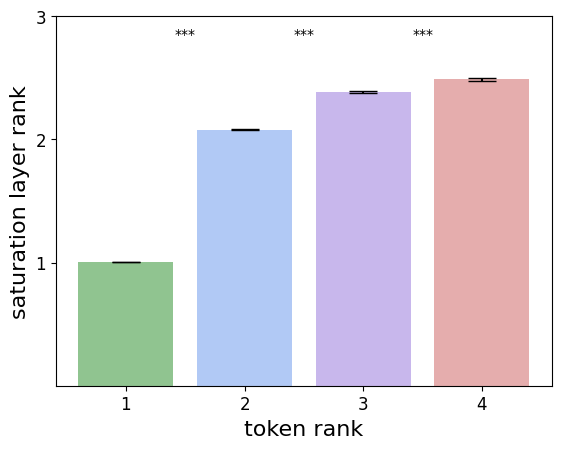

In [7]:
import matplotlib.pyplot as plt
from scipy import stats


def calc_top_k_saturation_layer_rank(saturation_layer_arr):
    """Computes the rank of saturation layers for top-k tokens."""
    saturation_layer_arr = np.array(saturation_layer_arr)
    relevant_indices = np.where(saturation_layer_arr[0] <= int(SATURATION_LAYER_RATIO * num_layers))[0]

    satur_layer_rank_dict = defaultdict(list)
    for ind in relevant_indices:
        sorted_satur_layers = np.sort(saturation_layer_arr[:, ind]).tolist()
        for j in range(TOP_K):
          cur_ind = sorted_satur_layers.index(saturation_layer_arr[j, ind])
          satur_layer_rank_dict[j].append(cur_ind)
    return satur_layer_rank_dict


def plot_saturation_layer_rank_vs_token_rank(layer_value_results, k=TOP_K):
  """Plots the saturation layer rank against token rank with t-test significance markers."""
  colors = ['forestgreen', 'cornflowerblue', 'mediumpurple', 'indianred']
  fig, ax = plt.subplots()
  ax.set_ylabel('saturation layer rank',  fontsize=16)
  ax.set_xlabel('token rank',  fontsize=16)
  ax.tick_params(axis='both', which='major', labelsize=12)

  means = [np.mean(layer_value_results[j])+1 for j in range(k)]
  stds = [np.std(layer_value_results[j])/np.sqrt(len(layer_value_results[j])) for j in range(k)]
  ax.bar([i+1 for i in range(k)], height=means, yerr=stds, align='center',
         color=colors, alpha=0.5, ecolor='black', capsize=10)
  ax.set_xticks([i+1 for i in range(k)])
  ax.set_yticks([i+1 for i in range(k-1)])

  #t-test
  for j in range(k-1):
    data1 = np.array(layer_value_results[j])
    data2 = np.array(layer_value_results[j+1])
    _, p_value = stats.ttest_ind(data1, data2, equal_var=False)
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else ""

    if significance:
      x1, x2 = j+1+0.1, j+2-0.1  # Positions of the boxes
      y, h, col = max(data1.max() + 1, data2.max() + 1) + 1, 0.4, 'k'  # y is height of the line
      ax.text((x1+x2)*.5, 2.8, significance, ha='center', va='bottom', color=col)

  ax = plt.gca()
  ax.set_ylim([0, 3])
  plt.show()


satur_layer_rank = calc_top_k_saturation_layer_rank(saturation_layer_arr)
plot_saturation_layer_rank_vs_token_rank(satur_layer_rank)

###2nd Experiment: Predicting task number from layer activations via probing
This section reproduces the second experiment from the paper, training a logistic regression classifier to predict the task index from intermediate layer embeddings.
Classifier accuracy should be around 0.85.

In [8]:
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import KFold


def get_training_data(num_classes):
    """Loads embeddings for all layers and creates balanced training data for probing."""
    aggregated_data = defaultdict(lambda: defaultdict(list))

    for text_idx in range(NUM_TEXTS):
        with open(f"layer_embds_{text_idx}.pkl", "rb") as file:
            layer_data = pickle.load(file)
            for layer, token_data in layer_data.items():
                for token_rank in range(num_classes):
                    aggregated_data[layer][token_rank].extend(token_data[token_rank])

    features, labels = [], []
    for layer, tokens_dict in aggregated_data.items():
        min_samples = min(len(tokens_dict[token_rank]) for token_rank in range(num_classes))
        if min_samples < MIN_NUM_SAMPLES_FOR_TRAINING:  # Skip insufficient data
            continue
        for token_rank in range(num_classes):
            samples = tokens_dict[token_rank][:min_samples]
            features.extend(samples)
            labels.extend([token_rank] * len(samples))

    return np.array(features), np.array(labels)


def train_logistic_regression(X_train, Y_train):
    """Trains one-vs-rest logistic regression"""
    clf = make_pipeline(StandardScaler(), OneVsRestClassifier(LogisticRegression(max_iter=1000)))
    clf.fit(X_train, Y_train)
    return clf


def run_logistic_regression_probing(features, labels):
    """Performs k-fold probing with logistic regression."""
    skf = KFold(n_splits=NUM_KFOLDS, shuffle=True)
    accuracy_scores = []

    for train_idx, test_idx in skf.split(features):
        X_train, X_test = features[train_idx], features[test_idx]
        Y_train, Y_test = labels[train_idx], labels[test_idx]

        clf = train_logistic_regression(X_train, Y_train)
        y_pred = clf.predict(X_test)
        acc_score = balanced_accuracy_score(Y_test, y_pred)
        accuracy_scores.append(acc_score)

    acc_scores = np.array(accuracy_scores)
    return acc_scores.mean(), acc_scores.std() / np.sqrt(len(acc_scores))


# Run probing task
features, labels = get_training_data(NUM_PROBING_CLASSES)
avg_acc, acc_ste = run_logistic_regression_probing(features, labels)

print(f'The classifier predicts token rank from intermediate layer activations with accuracy of {round(avg_acc,3)} +- {round(acc_ste,3)}')

The classifier predicts token rank from intermediate layer activations with accuracy of 0.904 +- 0.008
